# Bank Customer Churn Prediction 

Developed algorithms to predict customer churn probability based on labeled data via Python programming. [Dataset information](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers).

## Contents

* Part 0: Data Collection
* Part 1: Data Exploration
* Part 2: Feature Preprocessing
* Part 3: Model Training and Results Evaluation
* Part 4: Feature Importance Discussion

# Part 0: Data Collection


In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = "14AxaOeFb3V25AzkfFRR9cQF03XImVmkr"
file = drive.CreateFile({'id':id}) 
file.GetContentFile('bank_churn.csv')

import pandas as pd

df = pd.read_csv('bank_churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [ ]:
import pandas as pd
import numpy as np

churn_df = pd.read_csv('bank_churn.csv')

churn_df.head()
churn_df.info()
churn_df.nunique()
y = churn_df['Exited']

### Part 1.2:  Understand the features

In [ ]:
churn_df.isnull().sum()
churn_df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].describe()
import matplotlib.pyplot as plt
import seaborn as sns

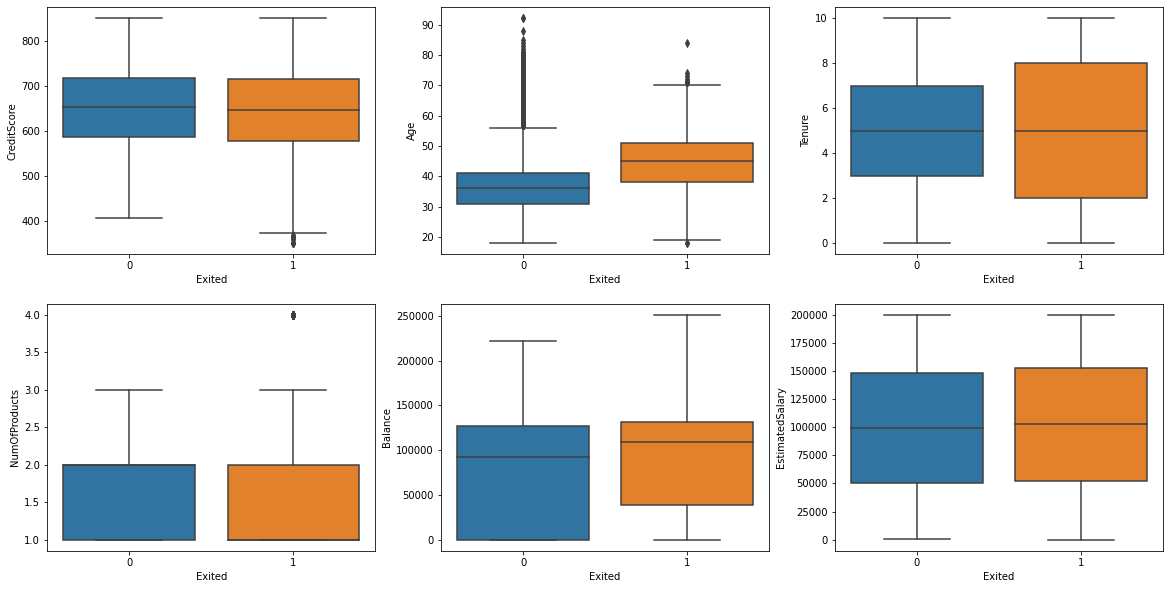

In [ ]:
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='Exited', y ='CreditScore', data=churn_df, ax=axss[0][0])
sns.boxplot(x='Exited', y ='Age', data=churn_df, ax=axss[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=churn_df, ax=axss[0][2])
sns.boxplot(x='Exited', y ='NumOfProducts', data=churn_df, ax=axss[1][0])
sns.boxplot(x='Exited', y ='Balance', data=churn_df, ax=axss[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=churn_df, ax=axss[1][2])

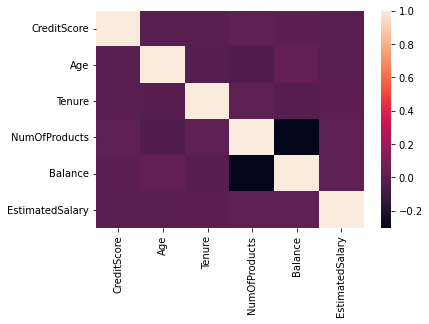

In [ ]:
corr_score = churn_df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].corr()

sns.heatmap(corr_score)

In [ ]:
corr_score

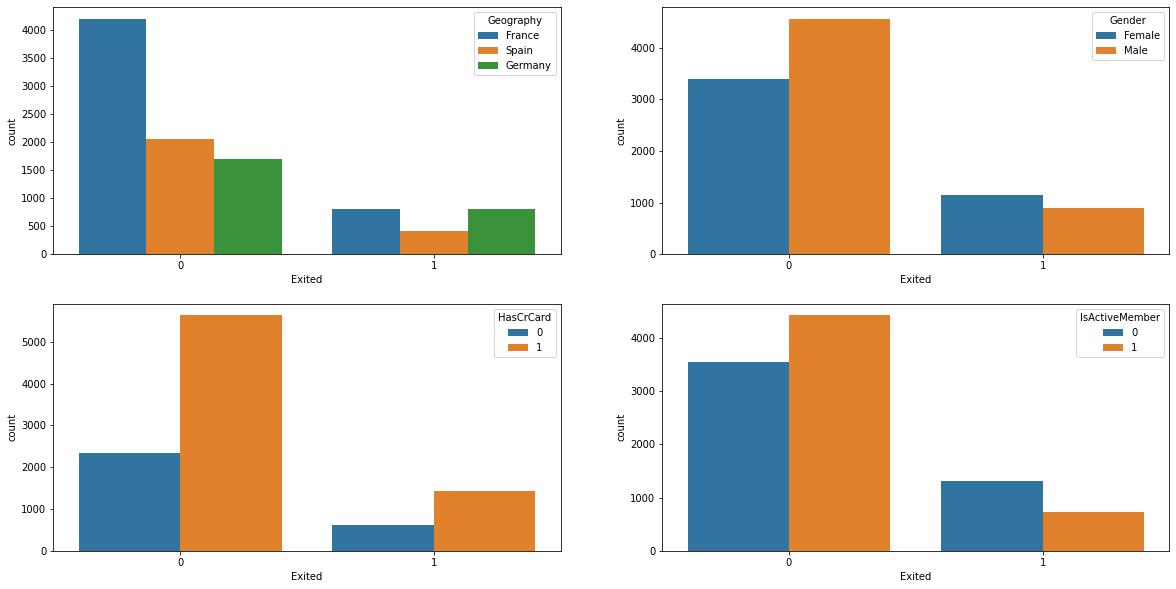

In [ ]:
_,axss = plt.subplots(2,2, figsize=[20,10])
sns.countplot(x='Exited', hue='Geography', data=churn_df, ax=axss[0][0])
sns.countplot(x='Exited', hue='Gender', data=churn_df, ax=axss[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=churn_df, ax=axss[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=churn_df, ax=axss[1][1])

# Part 2: Feature Preprocessing

In [ ]:
to_drop = ['RowNumber','CustomerId','Surname','Exited']
X = churn_df.drop(to_drop, axis=1)
X.head()
X.dtypes
cat_cols = X.columns[X.dtypes == 'O']
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')]
num_cols
cat_cols

Split dataset

In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')
X_train.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['Geography']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)
X_train.head()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

categories = ['Gender']
enc_oe = OrdinalEncoder()
enc_oe.fit(X_train[categories])

X_train[categories] = enc_oe.transform(X_train[categories])
X_test[categories] = enc_oe.transform(X_test[categories])
X_train.head()

Standardize/Normalize Data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_train.head()

# Part 3: Model Training and Result Evaluation

### Part 3.1: Model Training

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

classifier_logistic = LogisticRegression()

classifier_KNN = KNeighborsClassifier()

classifier_RF = RandomForestClassifier()

classifier_logistic.fit(X_train, y_train)

classifier_logistic.predict(X_test)

classifier_logistic.score(X_test, y_test)

model_names = ['Logistic Regression','KNN','Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

#### Part 3.2: Use Grid Search to Find Optimal Hyperparameters
alternative: random search

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

#### Part 3.2.1: Find Optimal Hyperparameters - LogisticRegression

In [ ]:
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01, 0.05, 0.1, 0.2, 1)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

print_grid_search_metrics(Grid_LR)
best_LR_model = Grid_LR.best_estimator_
best_LR_model.predict(X_test)
best_LR_model.score(X_test, y_test)

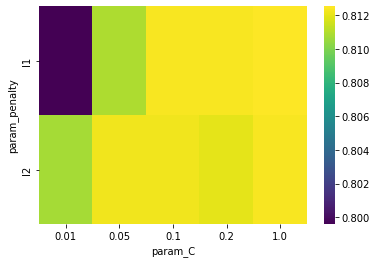

In [ ]:
LR_models = pd.DataFrame(Grid_LR.cv_results_)
res = (LR_models.pivot(index='param_penalty', columns='param_C', values='mean_test_score')
            )
_ = sns.heatmap(res, cmap='viridis')

#### Part 3.2.2: Find Optimal Hyperparameters: KNN

In [ ]:
parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)
print_grid_search_metrics(Grid_KNN)
best_KNN_model = Grid_KNN.best_estimator_

#### Part 3.2.3: Find Optimal Hyperparameters: Random Forest

In [ ]:
parameters = {
    'n_estimators' : [60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)
print_grid_search_metrics(Grid_RF)
best_RF_model = Grid_RF.best_estimator_
best_RF_model

####Part 3.3: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ()

def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)

In [ ]:
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(y_test, best_KNN_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

#### Part 3.4.1: ROC of RF Model

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
best_RF_model.predict_proba(X_test)

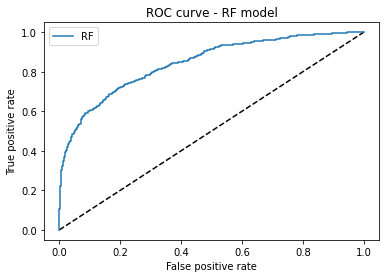

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn import metrics

metrics.auc(fpr_rf,tpr_rf)

#### Part 3.4.1: ROC of LR Model

In [ ]:
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresh = roc_curve(y_test, y_pred_lr)
best_LR_model.predict_proba(X_test)

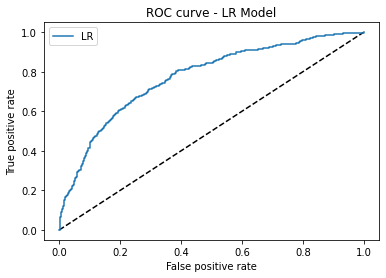

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
metrics.auc(fpr_lr,tpr_lr)

# Part 4: Feature Importance Discussion

### Part 4.1:  Logistic Regression Model

The corelated features

In [ ]:
X_with_corr = X.copy()

X_with_corr = OneHotEncoding(X_with_corr, enc_ohe, ['Geography'])
X_with_corr['Gender'] = enc_oe.transform(X_with_corr[['Gender']])
X_with_corr['SalaryInRMB'] = X_with_corr['EstimatedSalary'] * 6.4
X_with_corr.head()

In [ ]:
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_with_corr)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.04, solver='liblinear')
LRmodel_l1.fit(X_l1, y)

indices = np.argsort(abs(LRmodel_l1.coef_[0]))[::-1]

print ("Logistic Regression (L1) Coefficients")
for ind in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l1.coef_[0][indices[ind]], 4)))

In [ ]:
np.random.seed()
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1, solver='liblinear', random_state=42)
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]

indices = np.argsort(abs(LRmodel_l2.coef_[0]))[::-1]

print ("Logistic Regression (L2) Coefficients")
for ind in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l2.coef_[0][indices[ind]], 4)))

### Part 4.2:  Random Forest Model

In [ ]:
X_RF = X.copy()

X_RF = OneHotEncoding(X_RF, enc_ohe, ['Geography'])
X_RF['Gender'] = enc_oe.transform(X_RF[['Gender']])

X_RF.head()

In [ ]:
forest = RandomForestClassifier()
forest.fit(X_RF, y)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X_RF.columns[indices[ind]],round(importances[indices[ind]], 4)))